---
title: 'Perceptron'
author: 'Andre Xiao'
date: '2024-04-07'
image: 'perceptron.png'
description: 'Implementing and experimenting with the perceptron algorithm.'
format: html
code-annotations: hover
number-sections: true
---

![Image source: https://miro.medium.com/v2/resize:fit:1400/1*b7kNF1-TcrcogZAh2i5l4Q.png](https://miro.medium.com/v2/resize:fit:1400/1*b7kNF1-TcrcogZAh2i5l4Q.png)

Perceptron Implementation: [perceptron.py](https://github.com/andrexiao85/andrexiao85.github.io/blob/main/posts/perceptron_post/perceptron.py)

## Abstract

This post implements the perceptron algorithm and minibatch perceptron algorithm and performs various experiments using both. For the simple perceptron algorithm, I run the following experiments:

1. Visualize the updates of the perceptron for linearly separable data and the final separating line.
2. Visualize the updates of the perceptron for not linearly separable data and the final boundary line in the final iteration since it does not converge.
3. Visualize the loss of the perceptron for data with 5 feature and determine if it converges or not.

For the minibatch perceptron algorithm, I run the following experiments:

1. Visualize the updates of the perceptron with `k=1` and show that it performs similarly to the regular perceptron.
2. Visualize the updates of the perceptron with `k=10` and show it can still find a separating line in 2d.
3. Visualize the updates of the perceptron with `k=n` and show that it can still converge even if the data is not linearly separable, provided that the learning rate $\alpha$ is not separable.

At the end, I discuss the runtime complexity of a single iteration of both the regular perceptron algorithm and the minibatch perceptron algorithm.


## Implementing Perceptron

The perceptron algorithm aims to find a good choice of weights $\mathbf{w}$ that makes the loss small using the following algorithm:

1. Start with a *random* $\mathbf{w}^{(0)}$.
2. In each time-step $t$:
    + Pick a random data point $i\in{1,...,n}$
    + Compute $s^{(t)}_i = \langle\mathbf{w}^{(t)}, \mathbf{x}_i\rangle$.
    + If $s^{(t)}_i y_i \geq 0$, then point $i$ is correctly classified -- do nothing!
    + Else, if $s^{(t)}_i y_i < 0$, then perform update 
    $$\mathbf{w}^{(t+1)} =  \mathbf{w}^{(t)} + y_i\mathbf{x}_i.$$
    + These steps can also be written as:
    $$\mathbf{w}^{(t+1)} =  \mathbf{w}^{(t)} + \mathbb{1}[s_i y_i < 0]y_i\mathbf{x}_i.$$

The loss is defined to be the proportion of points that are *misclassified*.
The only differences with the minibatch algorithm is that for each time-step $t$, it picks $k$ random points $i_1,...,i_k$ instead of a single point and the update is defined as:
$$\mathbf{w}^{(t+1)} =  \mathbf{w}^{(t)} + \frac{\alpha}{k}\sum_{\ell=1}^k\mathbb{1}[s_{i_\ell} y_{i_\ell} < 0]y_{i_\ell}\mathbf{x}_{i_\ell}$$
where $\alpha$ is the learning rate hyperparameter which can be tuned to achieve good results.

My perceptron uses the function `perceptron.grad()` to calculate 
$$\mathbb{1}[s_i y_i < 0]y_i\mathbf{x}_i$$ 
for each iteration. 
The minibatch perceptron uses the function `perceptron.mbgrad()` to calculate
$$\frac{\alpha}{k}\sum_{\ell=1}^k\mathbb{1}[s_{i_\ell} y_{i_\ell} < 0]y_{i_\ell}\mathbf{x}_{i_\ell}$$
for each iteration.

Below are my implementations of `perceptron.grad()` and `perceptron.mbgrad()` in Python.

```python
def grad(self, X, y):
    s = X@self.w
    return (s*y < 0) * y*X

def mbgrad(self, X, y, k = 2, alpha = 0.1):
    s = X@self.w
    return sum(((s*y < 0) * y)[:, None] *X) * alpha / k
```

To test my implementation of the regular perceptron algorithm, I will generate a data set and run a minimal training loop that eventually achieves `loss = 0`.

In [1]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

But before running the test, I will first define some functions that will be used to generate and visualize the data.

In [2]:
import torch

def perceptron_data(n_points = 300, noise = 0.2, dims = 2): # <1>
    
    y = torch.arange(n_points) >= int(n_points/2) # <1>
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, dims)) # <1>
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # <1>

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1 # <1>

    return X, y # <1>

import matplotlib.pyplot as plt

def plot_perceptron_data(X, y, ax): # <2>
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2" # <2>
    targets = [-1, 1] # <2>
    markers = ["o" , ","] # <2>
    for i in range(2): # <2>
        ix = y == targets[i] # <2>
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i]) # <2>
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$") # <2>

def draw_line(w, x_min, x_max, ax, **kwargs): # <3>
    w_ = w.flatten() # <3>
    x = torch.linspace(x_min, x_max, 101) # <3>
    y = -(w_[0]*x + w_[2])/w_[1] # <3>
    l = ax.plot(x, y, **kwargs) # <3>

1. Generates perceptron data.
2. Plots perceptron data.
3. Draws decision boundary line.

I will also define a training loop function that runs the perceptron until `loss = 0` or the max amount of iterations is reached and a function that plots the decision boundary and loss for only updates during the training loop.

In [3]:
from functools import reduce

def plot_dims(n): # <1>
    lower_factors = [i for i in range(1, int(n**0.5) + 1) if n % i == 0] # <1>
    return lower_factors[-1], n//lower_factors[-1] # <1>

def training_loop(X, y, max_iters):
    p = Perceptron() # <2>
    opt = PerceptronOptimizer(p) # <2>
    torch.manual_seed(1) # <2>
    p.loss(X, y) # <2>

    n = X.size()[0] # <3>
    loss = 1 # <3>
    loss_vec = [] # <3>
    old_w_vec = [] # <3>
    p_w = [] # <3>
    local_loss_vec = [] # <3>
    i_vec = [] # <3>
    iters = 0 # <3>
    updates = 0 # <3>
    seed = 1 # <3>

    while loss > 0 and iters < max_iters: # <4>
        old_w = torch.clone(p.w) # <5>
        
        torch.manual_seed(seed) # <6>
        
        i = torch.randint(n, size = (1,)) # <7>
        x_i = X[[i],:] # <7>
        y_i = y[i] # <7>
        local_loss = opt.step(x_i, y_i) # <7>
        
        seed += 1

        if local_loss > 0: # <8>
            local_loss_vec.append(local_loss) # <8>
            i_vec.append(i) # <8>
            old_w_vec.append(old_w) # <8>
            p_w.append(torch.clone(p.w)) # <8>
            loss = p.loss(X, y).item() # <8>
            loss_vec.append(loss) # <8>
            updates += 1 # <8>
        iters += 1
        if iters >= max_iters:
            print('Max iterations reached.')

    return i_vec, loss_vec, old_w_vec, p_w, local_loss_vec, updates

def plot_updates(X, y, i_vec, loss_vec, local_loss, old_w, p_w): # <9>
    updates = len(loss_vec) # <9>
    rows, cols = plot_dims(updates) # <9>
    plt.rcParams["figure.figsize"] = (cols*2, rows*2) # <9>
    fig, axarr = plt.subplots(rows, cols, sharex = True, sharey = True) # <9>
    markers = ["o", ","] # <9>
    marker_map = {-1 : 0, 1 : 1} # <9>
    current_ax = 0 # <9>

    for j in range(updates): # <9>
        ax = axarr.ravel()[current_ax] # <9>
        i = i_vec[j] # <9>
        plot_perceptron_data(X, y, ax) # <9>
        draw_line(old_w[j], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed") # <9>
        draw_line(p_w[j], x_min = -1, x_max = 2, ax = ax, color = "black") # <9>
        ax.scatter(X[i,0], X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]]) # <9>
        ax.set_title(f"loss = {loss_vec[j]:.3f}") # <9>
        ax.set(xlim = (-1, 2), ylim = (-1, 2)) # <9>
        current_ax += 1 # <9>

    plt.tight_layout() # <9>

1. Generates dimensions for plotting the updates of the perceptron using the number of updates $n$ as the input.
2. Initialize perceptron.
3. Initialize variables for main loop.
4. Loop until `loss > 0` or max iterations reached.
5. Save the old value of $\mathbf{w}$ for plotting later.
6. Set seed for reproducible results.
7. Make an optimization step using random point `x_i`.
8. If a change was made, save values needed for plotting.
9. Function to plot updates.

Now, I can generate and plot my data set.

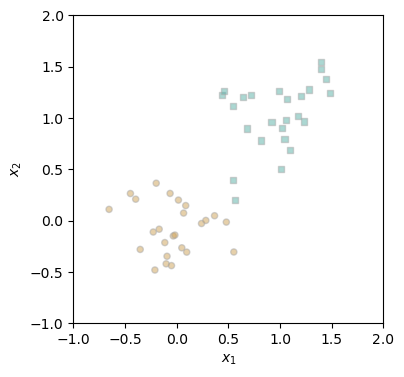

In [4]:
#| code-fold: true
#| fig-cap: Data to test my perceptron algorithm.
#| label: fig-test

torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Next, I run the minimal training loop and plot each update.

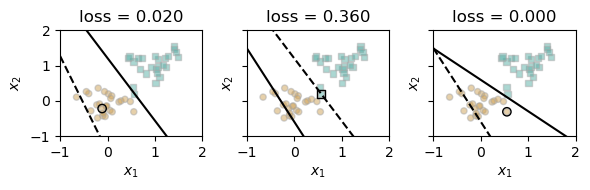

In [5]:
#| code-fold: true
#| fig-cap: The dotted lines represent the old decision boundaries and the solid lines represent the updated decision boundaries. The highlighted point represents the random point chosen to update $\mathbf{w}$.
#| label: fig-test-updates

i_vec, loss_vec, old_w, p_w, local_loss_vec, updates = training_loop(X, y, max_iters = 1000)
plot_updates(X, y, i_vec, loss_vec, local_loss_vec, old_w, p_w)

We can see that it eventually achieves `loss = 0` showing that my implementation was successful.

## Experimentation: Perceptron

For the regular perceptron, I will run the following experiments:

1. Visualize the updates of the perceptron for linearly separable data and the final separating line.
2. Visualize the updates of the perceptron for not linearly separable data and the final boundary line in the final iteration since it does not converge.
3. Visualize the loss of the perceptron for data with 5 feature and determine if it converges or not.

### Linearly Separable Data {#sec-p1}

First, I generate a linearly separable data set with 50 points. Below is the plot of the data.

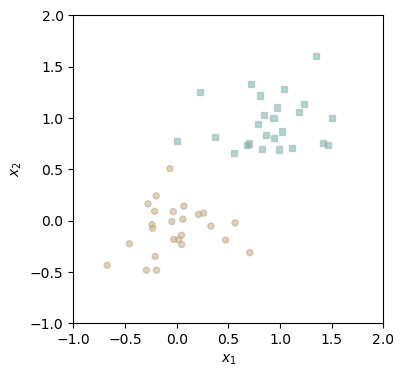

In [6]:
#| code-fold: true
#| fig-cap: Plot of linearly separable data (n = 50).
#| label: fig-e1

torch.manual_seed(1)
X1, y1 = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X1, y1, ax)

Now, I can run the minimal training loop and plot the loss and decision boundary for updates only.

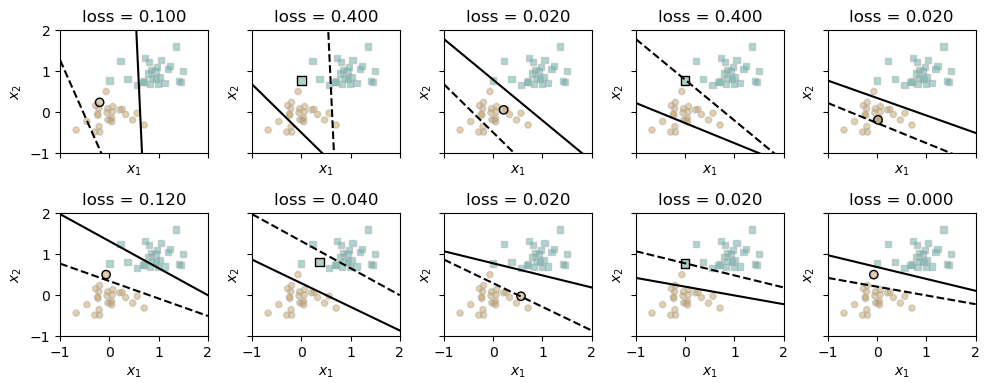

In [7]:
#| code-fold: true
#| fig-cap: Updates for P.1.
#| label: fig-e1-updates

i_vec, loss_vec, old_w, p_w, local_loss_vec, updates = training_loop(X1, y1, max_iters = 1000)
plot_updates(X1, y1, i_vec, loss_vec, local_loss_vec, old_w, p_w)

As we can see from the plots, the perceptron algorithm can successfully achieve `loss = 0` and found a separating line for linearly separable data.

### Not Linearly Separable {#sec-p2}

First, I will generate not linearly separable data with 50 points of data.

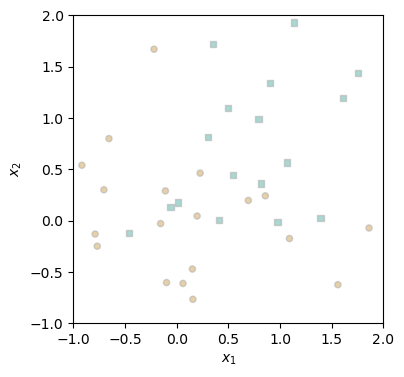

In [8]:
#| code-fold: true
#| fig-cap: Not linearly separable data (n = 50).
#| label: fig-e2

torch.manual_seed(1)
X2, y2 = perceptron_data(n_points = 50, noise = 0.99)
n = X2.size()[0]
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)

Now, I can run the minimal training loop on the data. Because the data is not linearly separable, the perceptron will not converge, so I set the max iterations `max_iters = 1000`.

In [9]:
i_vec, loss_vec, old_w, p_w, local_loss_vec, updates = training_loop(X2, y2, max_iters = 1000)

Max iterations reached.


We can see that the message confirms that the perceptron algorithm did not converge withing 1000 iterations. Below is the final decision boundary in the final iteration.

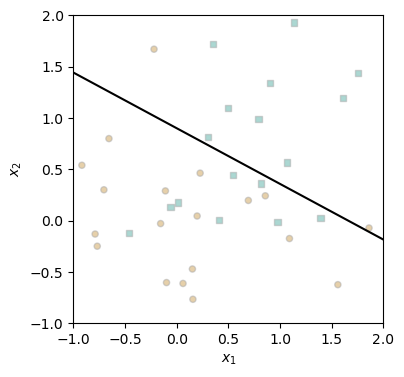

In [10]:
#| code-fold: true
#| fig-cap: The decision boundary in the final iteration.
#| label: fig-e2-result

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)
draw_line(p_w[-1], -1, 2, ax, color = "black")

### Data with Five Features

The perceptron algorithm should still work on data with more than two features. In this part, I will run the perceptron on data with five features.

First, I will generate the necessary data.

In [11]:
torch.manual_seed(37)
X3, y3 = perceptron_data(n_points = 100, noise = 0.3, dims = 5)

Then, I run the minimal training loop on the data and plot the loss over time.

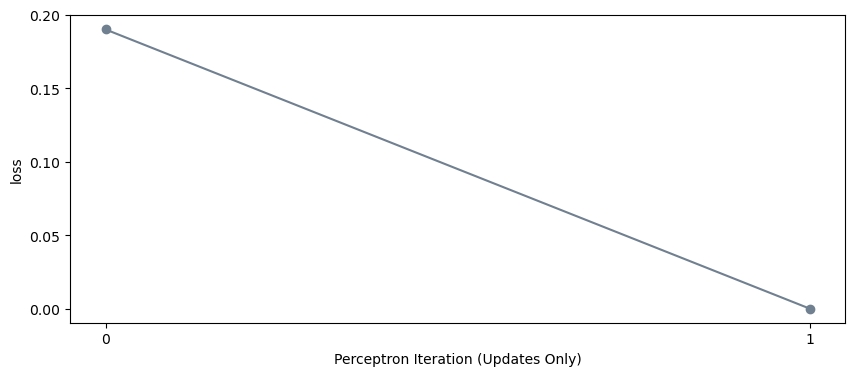

In [12]:
#| code-fold: true
#| fig-cap: Loss over time for updates only.
#| label: fig-e3-result

i_vec, loss_vec, old_w, p_w, local_loss_vec, updates = training_loop(X3, y3, max_iters = 1000)
plt.plot(loss_vec, color = "slategrey") # <1>
plt.scatter(torch.arange(updates), loss_vec, color = "slategrey") # <1>
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss") # <1>
xticks = torch.arange(0, updates) # <1>
plt.yticks([0, 0.05, 0.10, 0.15, 0.20]) # <1>
plt.xticks(xticks); # <1>

1. Plots loss over time for updates only.

Looking above, we can see that the perceptron algorithm achieved `loss = 0` meaning it successfully converged and found a separating line.

## Experimentation: Minibatch Perceptron

For the minibatch perceptron, I will be running the following experiments:
1. Visualize the updates of the perceptron with `k=1` and show that it performs similarly to the regular perceptron.
2. Visualize the updates of the perceptron with `k=10` and show it can still find a separating line in 2d.
3. Visualize the updates of the perceptron with `k=n` and show that it can still converge even if the data is not linearly separable, provided that the learning rate $\alpha$ is not separable. 

For the experiments, I will be using the data from @sec-p1 and @sec-p2.

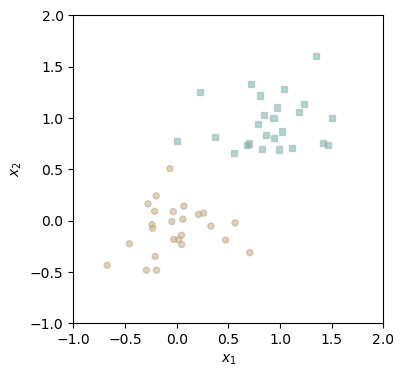

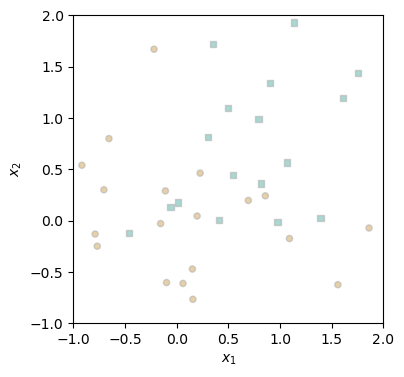

In [13]:
#| code-fold: true
#| fig-cap: 'Plots of data to be used.'
#| fig-subcap:
#|   - 'Linearly separable data from @sec-p1.'
#|   - 'Not linearly separable data from @sec-p2.'
#| layout-ncol: 2
#| label: fig-mb1

n = X1.size()[0]
fig, ax = plt.subplots(1, 1, figsize = (4, 4), sharex = True, sharey = True)
fig1, ax1 = plt.subplots(1, 1, figsize = (4, 4), sharex = True, sharey = True)
ax.set(xlim = (-1, 2), ylim = (-1, 2))
ax1.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X1, y1, ax)
plot_perceptron_data(X2, y2, ax1)

Before starting experimentation, I need to write a training loop for the minibatch perceptron. It will be the similar to the regular perceptron training loop with some minor changes.

In [14]:
def mb_training_loop(X, y, k = 1, alpha = 1, max_iters = 1000):

    p = Perceptron() 
    opt = PerceptronOptimizer(p) 
    torch.manual_seed(1)
    p.loss(X, y) 

    n = X.size()[0] 
    loss = 1
    loss_vec = []
    old_w_vec = []
    p_w = []
    local_loss_vec = []
    ix_vec = []
    
    iters = 0
    updates = 0
    seed = 1

    while loss > 0 and iters < max_iters:
        old_w = torch.clone(p.w)
        
        torch.manual_seed(seed)
        
        ix = torch.randperm(X.size(0))[:k] # <1>
        x_ix = X[ix,:] # <1>
        y_ix = y[ix] # <1>
        local_loss = opt.mbstep(x_ix, y_ix, k = k, alpha = alpha) # <1>
        seed += 1

        if local_loss > 0:
            local_loss_vec.append(local_loss)
            ix_vec.append(ix)
            old_w_vec.append(old_w)
            p_w.append(torch.clone(p.w))
            loss = p.loss(X, y).item()
            loss_vec.append(loss)
            updates += 1
        iters += 1
        if iters >= max_iters:
            print('Max iterations reached.')

    return ix_vec, loss_vec, old_w_vec, p_w, local_loss_vec, updates

def mb_plot_updates(X, y, ix_vec, loss_vec, local_loss, old_w, p_w):
    updates = len(loss_vec)
    rows, cols = plot_dims(updates)
    plt.rcParams["figure.figsize"] = (cols*2, rows*2)
    fig, axarr = plt.subplots(rows, cols, sharex = True, sharey = True)
    markers = ["o", ","]
    marker_map = {-1 : 0, 1 : 1}
    current_ax = 0

    for j in range(updates):
        ax = axarr.ravel()[current_ax]
        i = ix_vec[j]
        plot_perceptron_data(X, y, ax)
        draw_line(old_w[j], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        draw_line(p_w[j], x_min = -1, x_max = 2, ax = ax, color = "black")
        for k in i:
            ax.scatter(X[k,0],X[k,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[k].item()]])
        ax.set_title(f"loss = {loss_vec[j]:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1

    plt.tight_layout()

1. Makes optimization step using $k$ random points.

### `k = 1`

For this first experimentation, we want to show that the minibatch perceptron performs similarly to the regular perceptron. To do that, I will use the data from @fig-mb1-1 to compare results for linearly separable data and the data from @fig-mb1-2 for not linearly separable data.


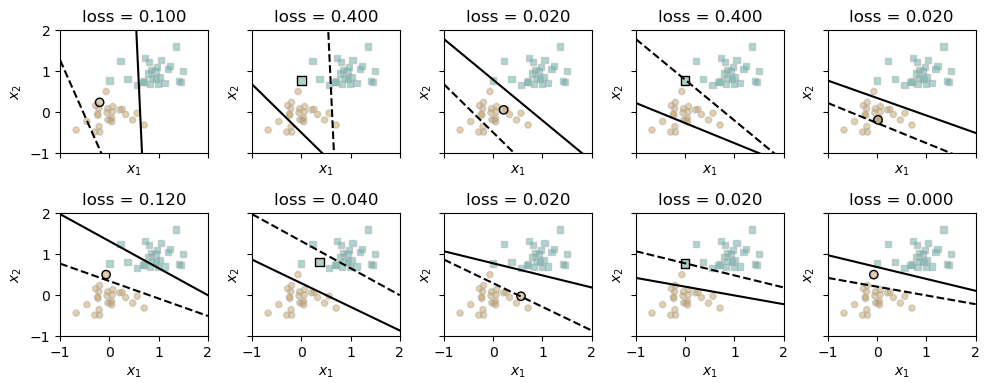

In [15]:
#| code-fold: true
#| fig-cap: Updates for linearly separable data.
#| label: fig-mb1-result1

ix_vec, loss_vec, old_w, p_w, local_loss_vec, updates = mb_training_loop(X1, y1, k = 1, alpha = 1, max_iters = 1000)
mb_plot_updates(X1, y1, ix_vec, loss_vec, local_loss_vec, old_w, p_w)

Next, let's run the loop for the not linearly separable data.

Max iterations reached.


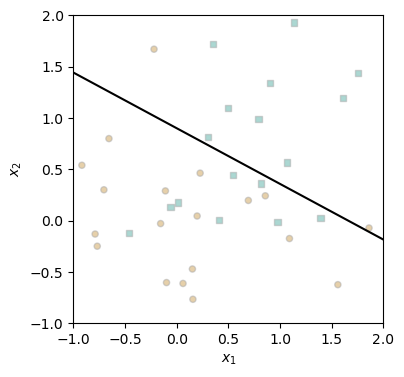

In [16]:
#| code-fold: true
#| fig-cap: Decision boundary during the final iteration.
#| label: fig-mb1-result2

ix_vec, loss_vec, old_w, p_w, local_loss_vec, updates = mb_training_loop(X2, y2, k = 1, alpha = 1, max_iters = 1000)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)
draw_line(p_w[-1], -1, 2, ax, color = "black")

Comparing @fig-mb1-result1 to @fig-e1-updates and @fig-mb1-result2 to @fig-e2-result, we can see that the final decision boundary is the same which confirms that the minibatch perceptron performs similarly to the regular perceptron for `k = 1`.

### `k = 10`

To show that the minibatch perceptron will converge for `k = 10` for linearly separable data, I will once again use the data from @fig-mb1-1.

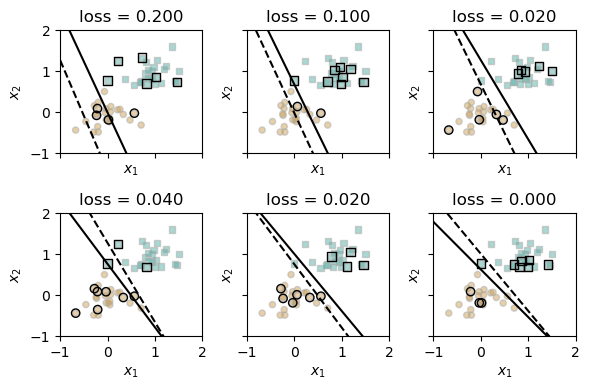

In [17]:
#| code-fold: true
#| fig-cap: Updates for `k = 10`.
#| label: fig-mb2-result

ix_vec, loss_vec, old_w, p_w, local_loss_vec, updates = mb_training_loop(X1, y1, k = 10, alpha = 1, max_iters = 1000)
mb_plot_updates(X1, y1, ix_vec, loss_vec, local_loss_vec, old_w, p_w)

We can see that that it eventually achieves `loss = 0` meaning that the minibatch perceptron will converge for `k = 10`.

### `k = n`

To show that the minibatch perceptron will converge for `k = n` even if the data is not linearly separable, I use the data from @fig-mb1-2. Even though it will not be able to achieve `loss = 0`, the `loss` should still even out at some `loss < 0.5`.

In [18]:
n = X2.size()[0]
ix_vec, loss_vec, old_w, p_w, local_loss_vec, updates = mb_training_loop(X2, y2, k = n, alpha = 0.001, max_iters = 1000)

Max iterations reached.


We can see that it did not achieve `loss = 0` within 1000 iterations. Let's take a look at the decision boundary during the final iteration, and the loss over time.

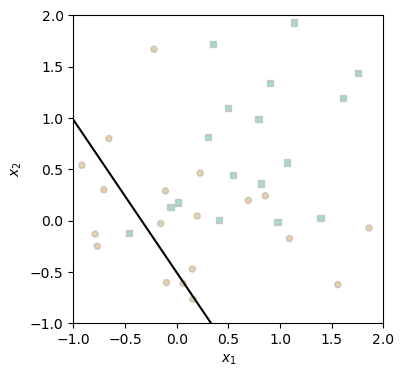

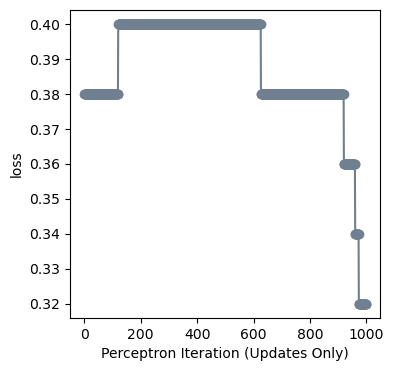

In [19]:
#| code-fold: true
#| fig-cap: Results of MB.3.
#| fig-subcap:
#|  - 'Decision boundary in the final iteration.'
#|  - 'Loss over time for updates only.'
#| layout-ncol: 2
#| label: fig-mb3

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)
draw_line(p_w[-1], -1, 2, ax, color = "black")

fig1, ax1 = plt.subplots(1, 1, figsize = (4, 4))
plt.plot(loss_vec, color = "slategrey")
ax1.scatter(torch.arange(updates), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
xticks = torch.arange(0, updates+1, 200)
plt.xticks(xticks);

In @fig-mb3-2, we can see that the loss eventually drops down to about 0.32 which confirms that the minibatch perceptron will converge to some value `loss < 0.5` for `k = n`.

## Runtime Complexity

From these experiments, we can conclude that the minibatch perceptron is more powerful than the regular perceptron. However, does it require more processing power and time to run the minibatch perceptron? More specifically, what are the runtime complexities for each iteration of both perceptron algorithms and are they dependent on the number of data points $n$ or the number of features $p$?

### Perceptron

To do this, let's review the perceptron algorithms and the code implementation of them. Going back to the update equation for the perceptron, we have 
$$\mathbf{w}^{(t+1)} =  \mathbf{w}^{(t)} + \mathbb{1}[s_i y_i < 0]y_i\mathbf{x}_i.$$
where 
$$s^{(t)}_i = \langle\mathbf{w}^{(t)}, \mathbf{x}_i\rangle.$$
To calculate the score $s_i^{(t)}$, we need to calculate the dot product for $\mathbf{w}^{(t)}$ and $\mathbf{x}_i$. Given $p$ features, to calculate $s_i$, the algorithm has a runtime complexity of $O(p)$. Then going through the rest of the equation we get:

1. $s_i y_i \to O(p + n)$
2. $\mathbb{1}[s_i y_i < 0] \to O(p + 2n)$
3. $\mathbb{1}[s_i y_i < 0]y_i \to O(p + 3n)$
4. $(\mathbb{1}[s_i y_i < 0]y_i)\mathbf{x}_i \to O(2p+3n) = O(p+n)$.

So, the runtime complexity for the regular perceptron algorithm is $O(n + p)$ meaning it is dependent on the number of data points $n$ and the number of features $p$.

### Minibatch Perceptron
For the minibatch perceptron, the update equation is defined as:
$$\mathbf{w}^{(t+1)} =  \mathbf{w}^{(t)} + \frac{\alpha}{k}\sum_{\ell=1}^k\mathbb{1}[s_{i_\ell} y_{i_\ell} < 0]y_{i_\ell}\mathbf{x}_{i_\ell}.$$
Similar to $s_i$, $s_{i_\ell}$ has a runtime complexity of $O(n)$ and likewise
$(\mathbb{1}[s_{i_\ell} y_{i_\ell} < 0]y_{i_\ell})\mathbf{x}_{i_\ell}$ has runtime complexity $O(2p + 3n) = O(p + n)$. We then do this $k$ times where $k$ is the number of randomly selected points. Assuming the worse case scenario of $k = n$, we get a runtime complexity of $O(np + n^2)$. Additionally, we must compute the sum of the resulting vectors for $k=n$ randomly selected points. Because each vector contains $p$ values and there are $n$ total vectors, the operation will have runtime complexity $O(np)$.
Then, the total runtime complexity is $O(2np + n^2) = O(np + n^2)$.

To summarize, the regular perceptron has a runtime complexity of $O(n + p)$ and the minibatch perceptron has a runtime complexity of $O(np + n^2)$. From this, we can see that though the minibatch perceptron is more powerful than the regular perceptron but as a tradeoff, requires more processing power and time to run.

## Discussion

From the experiments with the perceptron, we found that it could converge to a separating line for linearly separable data with two or more features, but will not be able to converge for not linearly separable data. Then from the experiments with the minibatch perceptron, we found that it performed exactly the same as the regular perceptron when `k = 1` and $\alpha = 1$ when using the same dataset and starting $\mathbf{w}$. That is, it found the same separating line with the same amount of updates for linearly separable data and the same decision boundary in the final iteration for not linearly separable data. This is due to the fact that the update to $\mathbf{w}$ for the minibatch perceptron becomes the same as the update to $\mathbf{w}$ for the regular perceptron when `k = 1` and $\alpha = 1$. Additionally, we found that the minibatch perceptron converges for `k = 10` for linearly separable data and it converges to a `loss < 0.5` for not linearly separable when `k = n`.

Comparing the two algorithms, we found that the minibatch perceptron is more powerful than the regular perceptron, but as a result, requires more processing time to run.




